We know the following, from the competition descrition.

**VARIABLE DESCRIPTIONS**:

- survival: Survival
    (0 = No; 1 = Yes)
- pclass: Passenger Class
    (1 = 1st; 2 = 2nd; 3 = 3rd)
- name: Name
- sex: Sex
- age: Age
- sibsp: Number of Siblings/Spouses Aboard
- parch: Number of Parents/Children Aboard
- ticket: Ticket Number
- fare: Passenger Fare
- cabin: Cabin
- embarked: Port of Embarkation
     (C = Cherbourg; Q = Queenstown; S = Southampton)

**SPECIAL NOTES**:

- Pclass is a proxy for socio-economic status (SES) -  1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower
- Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5
- With respect to the family relation variables (i.e. `sibsp` and `parch`)
some relations were ignored.  The following are the definitions used
for `sibsp` and `parch`.

  - Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
  - Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
  - Parent:   Mother or Father of Passenger Aboard Titanic
  - Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore `parch=0` for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.

# Notes

We don't have many data, so will use cross validation instead of a separate Validation set. This will give us a score not useful as a generalization error, but will use it anyway for selection (as it should be).

In [1]:
import pandas as pd
import numpy as np

test = pd.read_csv('../input/test.csv')
train = pd.read_csv('../input/train.csv')

## Simplifying final scoring via a downloaded version of survivors

Data comes from [http://biostat.mc.vanderbilt.edu/wiki/Main/DataSets](), where some other data sets are available.

In [2]:
# There is an all empty record at the end
compiled_data = pd.read_csv('../input/titanic3.csv').dropna(how='all')

# The quotes in the names are wrong for `test.csv` and `train.csv`.
#  In general we don't care, so they are modified on the fly for the generation of the output test set
test_for_merger = test.copy()
test_for_merger['Name'] = test_for_merger['Name'].apply(lambda x: x.replace('"',''))
compiled_data['Name'] = compiled_data['name'].apply(lambda x: x.replace('"',''))

# We use both `Name` and `Ticket` to merge, because some passenger have duplicated names (we were getting wrong lengths before)
y_test = test_for_merger.merge(compiled_data, left_on=['Name', 'Ticket'], 
                    right_on=['Name', 'ticket'], how='left').rename(columns={'survived': 'Survived'})['Survived'].astype('int')

In [3]:
y_test.hist(by=test_for_merger['Pclass'][test_for_merger['Sex'] == 'female'])
y_test.hist(by=test_for_merger['Pclass'][test_for_merger['Sex'] == 'male'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f9bcbe0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10faea278>]], dtype=object)

In [4]:
def generalization_error(prediction):
    print(((y_test - prediction) == 0).value_counts(normalize=True))

We will use the above data just to run the generalization error calculation, not for training, not for anything else.

In order to easily generate the CSV submission file when it is time to do so, we define the function below.

In [5]:
def csv_from_prediction(prediction, filename='submission.csv'):
    submission = pd.DataFrame(data={'PassengerId': test['PassengerId'], 'Survived': prediction.astype(int)})

    # This is what we do if we don't use 'index=False' below
    #submission.set_index('PassengerId', drop=True, inplace=True)
    submission.to_csv(filename, index=False)

Let's get our bases covered:

In [6]:
y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
X_test = test.copy()

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


In [8]:
X_train['Embarked'].value_counts()
# We can see 'S' is the most common value

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### Titles are collected from both sets, and ages set from global means

In [9]:
import re
titles = X_train['Name'].append(X_test['Name']).apply(lambda x: re.match('.*,([^\.]+)\..*', x)[1].strip()).unique()
titles = np.append(titles, ['PublicService', 'Middle'])
#title_equivalences = {'Don': 'Mr', 'Dona': 'Mrs', 'Mlle': 'Miss', 'Mme': 'Mrs',
#                      'Jonkheer': 'Sir', 'the Countess': 'Lady',
#                      'Col': 'Sir', 'Major': 'Sir',
#                      'Capt': 'PublicService', 'Rev': 'PublicService', 'Dr': 'PublicService'
#                     }
title_equivalences = {'Don': 'Middle', 'Dona': 'Middle', 'Mlle': 'Miss', 'Mme': 'Middle',
                      'Mr': 'Middle', 'Mrs': 'Middle',
                      'Jonkheer': 'Sir', 'the Countess': 'Lady',
                      'Col': 'Sir', 'Major': 'Sir',
                      'Capt': 'PublicService', 'Rev': 'PublicService', 'Dr': 'PublicService'
                     }

X_train['Title'] = X_train['Name'].apply(lambda x: re.match('.*,([^\.]+)\..*', x)[1].strip())
X_test['Title'] = X_test['Name'].apply(lambda x: re.match('.*,([^\.]+)\..*', x)[1].strip())
for k,v in title_equivalences.items():
    X_train.loc[X_train['Title'] == k, 'Title'] = v
    X_test.loc[X_test['Title'] == k, 'Title'] = v
    
#title_mapping = {v: k for k, v in enumerate(title_mapping)}  # A Dict
#title_mapping['Mme'] = title_mapping['Mrs']
#title_mapping['Mlle'] = title_mapping['Miss']
#title_mapping['the Countess'] = title_mapping['Lady']
#title_mapping['Don'] = title_mapping['Mr']
#title_mapping['Dona'] = title_mapping['Mrs']
#inverse_title_mapping = {v: k for k, v in title_mapping.items()}  # The inverse Dict

In [10]:
ticket_sizes = (X_train['Ticket'].append(X_test['Ticket'])).value_counts()
full_ages = X_train['Age'].append(X_test['Age'])
full_titles = X_train['Title'].append(X_test['Title'])
full_classes = X_train['Pclass'].append(X_test['Pclass'])
full_fares = X_train['Fare'].append(X_test['Fare'])
    
def data_munge(data):
    useless_fields = ['PassengerId']
    data.drop(useless_fields, axis=1, inplace=True, errors='ignore')
    
    # This is the most common value
    data['Embarked'].fillna('S', inplace=True)
    
    data['GroupSize'] = data['Ticket'].apply(lambda x: ticket_sizes[x])
    data['NameLength'] = data['Name'].apply(lambda x: len(x))
    #data['TicketLength'] = data['Ticket'].apply(lambda x: len(x))

    data['FamilyOnBoard'] = data['SibSp'] + data['Parch']
    data['FamilyOnBoardType'] = pd.cut(data['FamilyOnBoard'], np.array([0, 0.9, 1.9, 2.9, 4.9, 100]),
       labels=["single","couple", "three","small_family", "big_family"],
       include_lowest=True)
    data.drop('FamilyOnBoard', axis=1, inplace=True)
    
    data.loc[data['Cabin'].isnull(), 'Cabin'] = 'U0'    
    data['CabinFirstLetter'] = data['Cabin'].apply(lambda x: x[0] if type(x)==str else '')
    def number_or_zero(x):
        match = re.match('.*[^0-9]*([0-9]+)$', x)
        return match[1] if match else '0'
    #data['CabinNumber'] = data['Cabin'].apply(lambda x: re.match('.*[^0-9]*([0-9]+)$', x)[1])
    data['CabinNumber'] = data['Cabin'].apply(number_or_zero)
    data = pd.get_dummies(data, columns=['CabinFirstLetter', 'CabinNumber']).drop(['Cabin'], axis=1)

    def first_digit_or_zero(x):
        match = re.match('[^0-9]*([0-9]).*$', x)
        return match[1] if match else '0'
    data['TicketFirstDigit'] = data['Ticket'].apply(first_digit_or_zero)
    
    data['Fare'] = data.apply(lambda x: full_fares[(full_classes == x['Pclass'])].median() if np.isnan(x['Fare']) else x['Fare'],
              axis=1)
    data['Fare'] = data['Fare']/data['GroupSize']
    data['NormalizedFare'] = data['Fare']

    #data.loc[data['Fare'].isnan(), 'Fare'] = full_fares.loc[(full_classes == x['Pclass'])].median()
    #data['Fare'] = data['Fare'].fillna(X_train['Fare'].median())
    # Now, Fare is adapted to the
    data['FareBracket'] = pd.qcut(data['Fare'], q=4,
                           labels=["1","2", "3","4"])
    data = pd.get_dummies(data, columns=['FareBracket'])

    for k in titles:
        for c in data['Pclass'].unique():
            mean_title_age = full_ages.loc[(full_titles == k) & (full_classes == c)].mean()
            data.loc[(data['Title'] == k) & data['Age'].isnull(), 'Age'] = mean_title_age

            
    data = pd.get_dummies(data, columns=['Sex', 'Embarked', 'Pclass', 'FamilyOnBoardType']) #.drop(['Sex_male', 'Embarked_C', 'Pclass_3'], axis=1)

    data['Kid'] = np.zeros(np.shape(data['Title']))
    data.loc[(data['Title'] == 'Master') & (data['Age'] <= 16), 'Kid'] = 1
    data.loc[(data['Title'] == 'Miss') & (data['Age'] <= 13), 'Kid'] = 1
    
    #data['WithKid'] = np.zeros(np.shape(data['GroupSize']))
    data['KidWithParents'] = np.zeros(np.shape(data['GroupSize']))
    #(data['Sex_female'] == 1) & 
    #data.loc[(data['Parch'] >= 1) & (data['GroupSize'] >= 3) & 
    #           (data['Kid'] == 0), 'WithKid'] = 1
    data.loc[(data['Parch'] >= 1) & (data['GroupSize'] >= 3) & 
              (data['Kid'] != 0), 'KidWithParents'] = 1
    
    # Mother alone (widower, nanny, etc...)
    data['MotherAlone'] = np.zeros(np.shape(data['GroupSize']))
    data.loc[(data['Sex_female'] == 1) & (data['Kid'] == 0) &
             (data['SibSp'] == 0) & (data['Parch'] >= 1), 'MotherAlone'] = 1    
    data['FatherAlone'] = np.zeros(np.shape(data['GroupSize']))
    data.loc[(data['Sex_male'] == 1) & (data['Kid'] == 0) &
             (data['SibSp'] == 0) & (data['Parch'] >= 1), 'FatherAlone'] = 1  
    
    data['KidsAge'] = np.zeros(np.shape(data['GroupSize']))
    # Aggregate of all kids age under the same ticket (it would be harder for single mothers with lots of kids, no?)
    data['KidsAge'] = data.apply(lambda x: 
                                 data.loc[(data['Ticket'] == x['Ticket']) & (data['Kid'] == 1), "Age"].sum() *
                                 data.loc[(data['Ticket'] == x['Ticket']) & (data['Kid'] == 1), "Age"].count(), axis=1)    
    
    data['AgeGroup'] = pd.cut(data['Age'], np.array([0, 4.1, 11.1, 16.1, 21.1, 25.1, 35.1, 45.1, 100]),
                           labels=[1,2,3,4,5,6,7,8])    
    data = pd.get_dummies(data, columns=['Title', 'AgeGroup'])#.drop(['Age'], axis=1, errors='ignore')

    return data

In [11]:
X_train_ready = data_munge(X_train)

# Simplest attempts (baselines)

A random assignment should give a 50% accuracy.

In [12]:
random_prediction = np.random.randint(0,2,len(y_train))
print("{:.2f}% of accuracy".format(1- abs(y_train - random_prediction).sum()/len(y_train)))
((y_train - random_prediction) == 0).value_counts(normalize=True)

0.50% of accuracy


True     0.502806
False    0.497194
Name: Survived, dtype: float64

A majority assignment should be better because the results are unbalanced, and that would be the benchmark to beat.

In [13]:
y_train.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [14]:
majority_prediction = np.full(len(y_train),0)
print("{:.2f}% of accuracy".format(1- abs(y_train - majority_prediction).sum()/len(y_train)))
((y_train - majority_prediction) == 0).value_counts(normalize=True)

0.62% of accuracy


True     0.616162
False    0.383838
Name: Survived, dtype: float64

# Process Test the same way

In [15]:
X_test_ready = data_munge(X_test)

In [16]:
X_test_ready.columns.values

array(['Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'GroupSize',
       'NameLength', 'CabinFirstLetter_A', 'CabinFirstLetter_B',
       'CabinFirstLetter_C', 'CabinFirstLetter_D', 'CabinFirstLetter_E',
       'CabinFirstLetter_F', 'CabinFirstLetter_G', 'CabinFirstLetter_U',
       'CabinNumber_0', 'CabinNumber_1', 'CabinNumber_2', 'CabinNumber_3',
       'CabinNumber_4', 'CabinNumber_5', 'CabinNumber_6', 'CabinNumber_7',
       'CabinNumber_8', 'CabinNumber_9', 'TicketFirstDigit',
       'NormalizedFare', 'FareBracket_1', 'FareBracket_2', 'FareBracket_3',
       'FareBracket_4', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'FamilyOnBoardType_single', 'FamilyOnBoardType_couple',
       'FamilyOnBoardType_three', 'FamilyOnBoardType_small_family',
       'FamilyOnBoardType_big_family', 'Kid', 'KidWithParents',
       'MotherAlone', 'FatherAlone', 'KidsAge', 'Title_Master',
       'Title_Middle', 'Title_Miss', 

In [17]:
len(X_test_ready.columns)

64

In [18]:
len(X_train_ready.columns)

66

Just in case there are some columns in train that are not available in test, due to the dummification

In [19]:
for i in np.setdiff1d(X_train_ready.columns.values, X_test_ready.columns.values):
    X_test_ready[i] = 0

# Proper learning going on

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import export_graphviz
import graphviz

In [21]:
X_test_ready.columns

Index(['Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'GroupSize',
       'NameLength', 'CabinFirstLetter_A', 'CabinFirstLetter_B',
       'CabinFirstLetter_C', 'CabinFirstLetter_D', 'CabinFirstLetter_E',
       'CabinFirstLetter_F', 'CabinFirstLetter_G', 'CabinFirstLetter_U',
       'CabinNumber_0', 'CabinNumber_1', 'CabinNumber_2', 'CabinNumber_3',
       'CabinNumber_4', 'CabinNumber_5', 'CabinNumber_6', 'CabinNumber_7',
       'CabinNumber_8', 'CabinNumber_9', 'TicketFirstDigit', 'NormalizedFare',
       'FareBracket_1', 'FareBracket_2', 'FareBracket_3', 'FareBracket_4',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'FamilyOnBoardType_single',
       'FamilyOnBoardType_couple', 'FamilyOnBoardType_three',
       'FamilyOnBoardType_small_family', 'FamilyOnBoardType_big_family', 'Kid',
       'KidWithParents', 'MotherAlone', 'FatherAlone', 'KidsAge',
       'Title_Master', 'Title_Middle', 'Title_Miss', 'Title_

In [22]:
#features_ignored = ['Name', 'Title', 'Ticket', 'Parch', 'SibSp']
#features_ignored = ['Name', 'Ticket', 'TicketLength', 'Parch', 'SibSp']
features_ignored = ['Name', 'Ticket', 'TicketLength', 'NameLength', 'Fare', 'Parch', 'SibSp', 'NormalizedFare']

X_train_ready = X_train_ready.drop(features_ignored, axis=1, errors='ignore')
X_test_ready = X_test_ready.drop(features_ignored, axis=1, errors='ignore')

In [23]:
print(cross_val_score(DecisionTreeClassifier(), X_train_ready, y_train))
cross_val_score(RandomForestClassifier(n_estimators=10), X_train_ready, y_train).mean()

[ 0.77777778  0.79461279  0.76094276]


0.80695847362514028

In [24]:
cross_val_score(RandomForestClassifier(n_estimators=100, min_samples_split=19, min_samples_leaf=2),
                X_train_ready, y_train).mean()

0.81481481481481488

In [25]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=19, min_samples_leaf=2)
model.fit(X_train_ready, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=19, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [26]:
prediction = model.predict(X_test_ready)
generalization_error(prediction)
# I used to keep this result, but now it is quite bad (and it improved just by cleaning the notebook um??)

False    0.672249
True     0.327751
Name: Survived, dtype: float64


In [27]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_ready, y_train)
prediction = model.predict(X_test_ready)
generalization_error(prediction)

False    0.626794
True     0.373206
Name: Survived, dtype: float64


In [28]:
#tree_dot = export_graphviz(model.estimators_[1], out_file=None, feature_names=X_test.drop(['Name', 'Ticket', 'Cabin'], axis=1).columns, filled=True)
#graphviz.Source(tree_dot, format="png")

In [29]:
#%%time
#param_grid = { 'criterion': ['gini', 'entropy'],
#               'n_estimators': np.round(np.logspace(1, 3,num=10)).astype(int),
#               'min_samples_leaf': np.arange(1, 5),
#               'min_samples_split' : np.arange(4, 18, 2),
#               'max_depth': np.arange(4,6, 1)}
#grid = GridSearchCV(RandomForestClassifier(warm_start=True, n_jobs=-1), param_grid=param_grid, cv=5)
#grid.fit(X_train_ready, y_train)

In [30]:
#print(grid.best_estimator_)
#print(grid.best_score_)

In [31]:
##prediction = grid.predict(X_train_ready)
##print( ((y_train - prediction) == 0).value_counts(normalize=True) )
#
#prediction = grid.predict(X_test_ready)
#generalization_error(prediction)

Let's refit with the parameters identified:

In [32]:
rfc = RandomForestClassifier(warm_start=True, n_jobs=-1,
                             n_estimators=130, criterion='entropy',
                             max_depth=4, 
                             min_samples_leaf=1, min_samples_split=8)
rfc.fit(X_train_ready, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=130, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=True)

In [33]:
prediction = rfc.predict(X_train_ready)
print(((y_train - prediction) == 0).value_counts(normalize=True))

True     0.835017
False    0.164983
Name: Survived, dtype: float64


In [34]:
#prediction = grid.predict(X_test.drop(features_ignored, axis=1))
#csv_from_prediction(prediction, filename='submission_tree_3.csv')

prediction = rfc.predict(X_test_ready)
#csv_from_prediction(prediction, filename='submission_tree_4.csv')
generalization_error(prediction)

False    0.660287
True     0.339713
Name: Survived, dtype: float64


In [35]:
feature_importances = pd.DataFrame()
for est in rfc.estimators_:
    feature_importances = feature_importances.append(pd.Series(est.feature_importances_, 
                                        index= X_test_ready.columns),
                             ignore_index=True)
feature_importances.mean().sort_values(ascending=False)

Sex_male                          0.197220
Embarked_C                        0.195797
FamilyOnBoardType_single          0.067406
Title_Ms                          0.050977
Title_PublicService               0.050810
CabinNumber_0                     0.047478
FareBracket_1                     0.044609
Age                               0.033227
CabinNumber_1                     0.032756
GroupSize                         0.031207
Sex_female                        0.029770
Pclass_2                          0.028631
Title_Master                      0.023346
FamilyOnBoardType_couple          0.012561
Pclass_3                          0.012100
FareBracket_2                     0.010869
Kid                               0.010482
FamilyOnBoardType_small_family    0.008826
Title_Miss                        0.008756
KidWithParents                    0.008332
Pclass_1                          0.008187
FatherAlone                       0.006680
AgeGroup_3                        0.006447
CabinFirstL

Let's try with **two** decision trees, one per biological sex

In [36]:
features_ignored_female = ['Sex_female', 'Sex_male','CabinFirstLetter_A', 'CabinFirstLetter_B',
       'CabinFirstLetter_C', 'CabinFirstLetter_D', 'CabinFirstLetter_E',
       'CabinFirstLetter_F', 'CabinFirstLetter_G', 'CabinFirstLetter_T',
       'CabinFirstLetter_U', 'CabinNumber_0', 'CabinNumber_1', 'CabinNumber_2',
       'CabinNumber_3', 'CabinNumber_4', 'CabinNumber_5', 'CabinNumber_6',
       'CabinNumber_7', 'CabinNumber_8', 'CabinNumber_9', 'TicketFirstDigit',
       'FareBracket_1', 'FareBracket_2', 'FareBracket_3', 'FareBracket_4',
       'Title_Lady',
       'Title_Master', 'Title_Middle', 'Title_Miss', 'Title_Ms',
       'Title_PublicService', 'Title_Sir', 'FatherAlone']
features_ignored_male = ['Sex_female', 'Sex_male', 'Title_Ms', 'Title_Miss', 'Title_Master', 'MotherAlone']

X_train_ready_female = X_train_ready[X_train_ready['Sex_female'] == 1].drop(features_ignored_female,
                                                                            axis=1, errors='ignore')
y_train_female = y_train[X_train_ready['Sex_female'] == 1]
X_train_ready_male = X_train_ready[X_train_ready['Sex_male'] == 1].drop(features_ignored_male, axis=1,
                                                                        errors='ignore')
y_train_male = y_train[X_train_ready['Sex_male'] == 1]

# Because of using two decision trees, we need to split our test per biological sex and then rejoin
X_test_ready_female = X_test_ready[X_test_ready['Sex_female'] == 1].drop(features_ignored_female,
                                                                         axis=1, errors='ignore')
X_test_ready_male = X_test_ready[X_test_ready['Sex_male'] == 1].drop(features_ignored_male,
                                                                     axis=1, errors='ignore')

In [37]:
X_train_ready_male.columns

Index(['Age', 'GroupSize', 'CabinFirstLetter_A', 'CabinFirstLetter_B',
       'CabinFirstLetter_C', 'CabinFirstLetter_D', 'CabinFirstLetter_E',
       'CabinFirstLetter_F', 'CabinFirstLetter_G', 'CabinFirstLetter_T',
       'CabinFirstLetter_U', 'CabinNumber_0', 'CabinNumber_1', 'CabinNumber_2',
       'CabinNumber_3', 'CabinNumber_4', 'CabinNumber_5', 'CabinNumber_6',
       'CabinNumber_7', 'CabinNumber_8', 'CabinNumber_9', 'TicketFirstDigit',
       'FareBracket_1', 'FareBracket_2', 'FareBracket_3', 'FareBracket_4',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'FamilyOnBoardType_single', 'FamilyOnBoardType_couple',
       'FamilyOnBoardType_three', 'FamilyOnBoardType_small_family',
       'FamilyOnBoardType_big_family', 'Kid', 'KidWithParents', 'FatherAlone',
       'KidsAge', 'Title_Lady', 'Title_Middle', 'Title_PublicService',
       'Title_Sir', 'AgeGroup_1', 'AgeGroup_2', 'AgeGroup_3', 'AgeGroup_4',
       'AgeGroup_5', 'AgeGroup_6'

In [38]:
%%time
param_grid = { 'criterion': ['gini', 'entropy'],
               'n_estimators': np.round(np.logspace(1, 3,num=10)).astype(int),
               'min_samples_leaf': [3],#np.arange(1, 5),
               'min_samples_split' : np.arange(6, 18, 2),
               'max_depth': np.arange(4,6, 1)}
grid_female = GridSearchCV(RandomForestClassifier(warm_start=True, n_jobs=-1), param_grid=param_grid, cv=5)
grid_female.fit(X_train_ready_female, y_train_female)

print(grid_female.best_score_)
prediction = grid_female.predict(X_train_ready_female)
print(((y_train_female - prediction) == 0).value_counts(normalize=True))

prediction_female = grid_female.predict(X_test_ready_female)
result_female = X_test_ready_female.join(pd.Series(prediction_female, name='Survived', index=X_test_ready_female.index))

0.81847133758
True     0.815287
False    0.184713
Name: Survived, dtype: float64
CPU times: user 6min 37s, sys: 45.9 s, total: 7min 23s
Wall time: 10min 58s


In [39]:
#%%time
#param_grid_dt = { 'criterion': ['gini', 'entropy'],
#                 'min_samples_leaf': np.arange(1, 5),
#               'min_samples_split' : np.arange(2, 18, 2),
#               'max_depth': np.arange(4,6, 1)}
#grid_female_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid_dt, cv=5)
#grid_female_dt.fit(X_train_ready_female, y_train_female)
#
#print(grid_female_dt.best_score_)
#prediction_dt = grid_female_dt.predict(X_train_ready_female)
#print(((y_train_female - prediction_dt) == 0).value_counts(normalize=True))
#
#prediction_female_dt = grid_female_dt.predict(X_test_ready_female)
#result_female_dt = X_test_ready_female.join(pd.Series(prediction_female_dt, name='Survived', index=X_test_ready_female.index))
#
#prediction_female = prediction_female_dt
#result_female = result_female_dt
#print(grid_female_dt.best_params_)

In [40]:
grid_female.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            n_estimators=17, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=True)

In [161]:
rfc_female = RandomForestClassifier(warm_start=True, n_jobs=-1,
                             n_estimators=500, criterion='gini',
                             max_depth=4, max_features=None,
                             min_samples_leaf=1, min_samples_split=8)
rfc_female.fit(X_train_ready_female, y_train_female)
prediction = rfc_female.predict(X_train_ready_female)
print(((y_train_female - prediction) == 0).value_counts(normalize=True))

prediction_female = rfc_female.predict(X_test_ready_female)
result_female = X_test_ready_female.join(pd.Series(prediction_female, name='Survived', index=X_test_ready_female.index))

rfc_male = RandomForestClassifier(warm_start=True, n_jobs=-1,
                             n_estimators=500, criterion='gini',
                             max_depth=4, max_features=None, 
                             min_samples_leaf=1, min_samples_split=8)
rfc_male.fit(X_train_ready_male, y_train_male)
prediction = rfc_male.predict(X_train_ready_male)
print(((y_train_male - prediction) == 0).value_counts(normalize=True))

prediction_male = rfc_male.predict(X_test_ready_male)
result_male = X_test_ready_male.join(pd.Series(prediction_male, name='Survived', index=X_test_ready_male.index))

# Now, let's join them and resort
prediction = result_female.append(result_male).sort_index()['Survived']
generalization_error(prediction)

csv_from_prediction(prediction, filename='submission_dual_tree.csv')

True     0.853503
False    0.146497
Name: Survived, dtype: float64
True     0.868284
False    0.131716
Name: Survived, dtype: float64
True     0.799043
False    0.200957
Name: Survived, dtype: float64


Below, an attempt to have differentr decision RFCs per class (which renders around a 68% of success).

In [66]:
#X_train_ready_class_1 = X_train_ready[X_train_ready['Pclass_1'] == 1]
#y_train_class_1 = y_train[X_train_ready['Pclass_1'] == 1]
#X_train_ready_class_2 = X_train_ready[X_train_ready['Pclass_2'] == 1]
#y_train_class_2 = y_train[X_train_ready['Pclass_2'] == 1]
#X_train_ready_class_3 = X_train_ready[X_train_ready['Pclass_3'] == 1]
#y_train_class_3 = y_train[X_train_ready['Pclass_3'] == 1]
#
#rfc_class_1 = RandomForestClassifier(n_jobs=-1,
#                             n_estimators=130, criterion='entropy',
#                             max_depth=4, 
#                             min_samples_leaf=1, min_samples_split=8)
#rfc_class_1.fit(X_train_ready_class_1, y_train_class_1)
#
#rfc_class_2 = RandomForestClassifier(n_jobs=-1,
#                            n_estimators=130, criterion='entropy',
#                            max_depth=4, 
#                            min_samples_leaf=1, min_samples_split=8)
#rfc_class_2.fit(X_train_ready_class_2, y_train_class_2)
#
#rfc_class_rest = RandomForestClassifier(n_jobs=-1,
#                             n_estimators=130, criterion='entropy',
#                             max_depth=4, 
#                             min_samples_leaf=1, min_samples_split=8)
#rfc_class_rest.fit(X_train_ready_class_3, y_train_class_3)
#
#prediction = rfc_class_1.predict(X_train_ready_class_1)
#print(((y_train_class_1 - prediction) == 0).value_counts(normalize=True))
#prediction = rfc_class_2.predict(X_train_ready_class_2)
#print(((y_train_class_2 - prediction) == 0).value_counts(normalize=True))
#prediction = rfc_class_3.predict(X_train_ready_class_3)
#print(((y_train_class_3 - prediction) == 0).value_counts(normalize=True))
#
## Because of using two decision trees, we need to split our test per biological sex and then rejoin
#X_test_ready_class_1 = X_test_ready[X_test_ready['Pclass_1'] == 1]
#X_test_ready_class_2 = X_test_ready[X_test_ready['Pclass_2'] == 1]
#X_test_ready_class_3 = X_test_ready[X_test_ready['Pclass_3'] == 1]
#
#prediction_class_1 = rfc_class_1.predict(X_test_ready_class_1)
#prediction_class_2 = rfc_class_2.predict(X_test_ready_class_2)
#prediction_class_3 = rfc_class_3.predict(X_test_ready_class_3)
#result_class_1 = X_test_ready_class_1.join(pd.Series(prediction_class_1, name='Survived', index=X_test_ready_class_1.index))
#result_class_2 = X_test_ready_class_2.join(pd.Series(prediction_class_2, name='Survived', index=X_test_ready_class_2.index))
#result_class_3 = X_test_ready_class_3.join(pd.Series(prediction_class_3, name='Survived', index=X_test_ready_class_3.index))
#
## Now, let's join them and resort
#prediction = result_class_1.append(result_class_2).append(result_class_3).sort_index()['Survived']
#generalization_error(prediction)
#
##csv_from_prediction(prediction, filename='submission_dual_tree.csv')



In [162]:
errors = (X_test.join(pd.Series(prediction, name='Survived')).join(pd.Series(X_test_ready['Age'], name='NewAge')))[(y_test - prediction) != 0]
#errors[errors['Survived'] == 1]
##['Pclass'].value_counts()
#print(X_train['Pclass'].value_counts(normalize=True))
#print(X_test['Pclass'].value_counts(normalize=True))
#errors['Pclass'].value_counts()
#print("--- Survived per class (errors) ---")
#print(errors['Pclass'].groupby(errors['Survived']).value_counts())
#print("--- Family type per class (errors) ---")
#print(errors['Pclass'].groupby(errors['FamilyOnBoardType']).value_counts())
#print("--- Family type per survived (errors) ---")
#print(errors['FamilyOnBoardType'].groupby(errors['Survived']).value_counts(normalize=True))
#print(errors['Survived'].value_counts())
#errors[errors['Survived'] == 1]
#
a = X_test_ready.join(pd.Series(y_test, name='Survived')).join(X_test['Name'])
#a[((y_test - prediction) == 0) & (a['Sex'] == 'female') & (a['FamilyOnBoardType'] == 'single')]
#X_test.loc[(a['Survived'] ==0) & (a["MotherAlone"] != 0.0)]
errors.loc[(errors['Survived'] ==1) & (errors['NewAge'].between(7,19))]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,GroupSize,NameLength,FamilyOnBoardType,CabinFirstLetter,CabinNumber,Survived,NewAge
66,3,"Burns, Miss. Mary Delia",female,18.0,0,0,330963,7.8792,U0,Q,Miss,1,23,single,U,0,1,18.000000
113,3,"Buckley, Miss. Katherine",female,18.5,0,0,329944,7.2833,U0,Q,Miss,1,24,single,U,0,1,18.500000
216,3,"Mahon, Miss. Bridget Delia",female,NaN,0,0,330924,7.8792,U0,Q,Miss,1,26,single,U,0,1,17.360874
227,3,"McNeill, Miss. Bridget",female,NaN,0,0,370368,7.7500,U0,Q,Miss,1,22,single,U,0,1,17.360874
238,2,"Hiltunen, Miss. Marta",female,18.0,1,1,250650,13.0000,U0,S,Miss,1,21,three,U,0,1,18.000000
273,3,"Lennon, Miss. Mary",female,NaN,1,0,370371,15.5000,U0,Q,Miss,2,18,couple,U,0,1,17.360874
282,3,"Fleming, Miss. Honora",female,NaN,0,0,364859,7.7500,U0,Q,Miss,1,21,single,U,0,1,17.360874
315,3,"Hagardon, Miss. Kate",female,17.0,0,0,AQ/3. 30631,7.7333,U0,Q,Miss,1,20,single,U,0,1,17.000000
410,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,U0,Q,Miss,1,22,single,U,0,1,17.360874


In [163]:
# Minimum is 94-91 - 84!
len(errors)

84

<IPython.core.display.Javascript object>


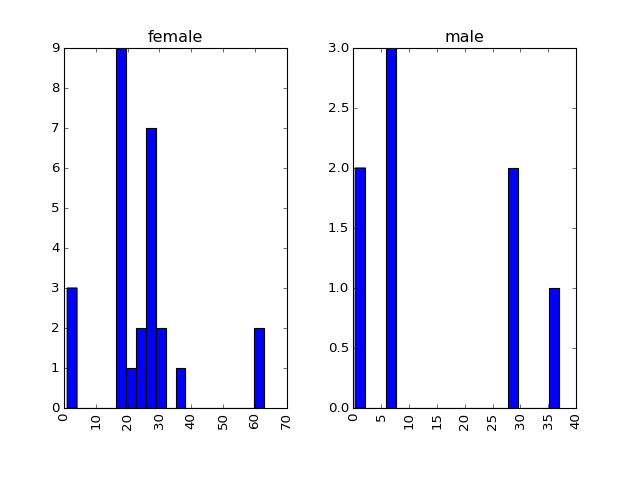

<IPython.core.display.Javascript object>


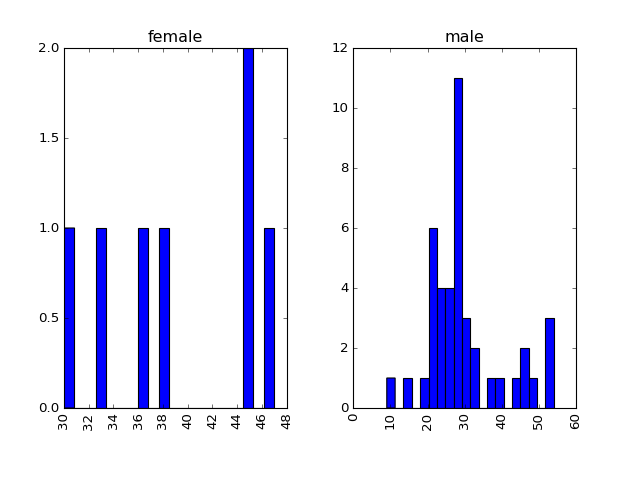

array([<matplotlib.axes._subplots.AxesSubplot object at 0x112f23518>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x115288eb8>], dtype=object)

In [165]:
%matplotlib notebook

full_x_test = X_test_ready.join(pd.Series(prediction, name='Survived')).join(X_test[['Sex', 'Pclass']])

full_x_test['Age'][(full_x_test['Survived'] == 1) & ((y_test - prediction) != 0)].hist(by=full_x_test['Sex'],bins=20)
full_x_test['Age'][(full_x_test['Survived'] == 0) & ((y_test - prediction) != 0)].hist(by=full_x_test['Sex'],bins=20)
#full_x_test['Fare'][((y_test - prediction) != 0)].hist(by=full_x_test['Pclass'])
#full_x_test['NormalizedFare'].hist(by=full_x_test['Pclass'])

In [46]:
#full_x_test[full_x_test['Fare'] >68 ]

In [164]:
#csv_from_prediction(prediction, filename='submission_0309_1854.csv')

In [48]:
import matplotlib.pyplot as plt
%matplotlib notebook

## Before we where considering : X_test, not our engineered version of it
#
#full_x_test = X_test_ready.join(pd.Series(prediction, name='Survived'))
#corr = X_test_ready.corr()
#plt.matshow(corr, 
#            interpolation='nearest', cmap=plt.cm.viridis, )
#plt.yticks(np.arange(len(corr.columns)), corr.columns)
#plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation='vertical')
#plt.colorbar()
#
#for (i, j), z in np.ndenumerate(corr):
#    plt.text(j, i, "{:.2f}".format(z), ha='center', va='center')
#
#    
## Analyze what went wrong 
#full_x_test_wrong = full_x_test.join(pd.Series(y_test - prediction, name='Wrong'))
#
#corr_wrong = full_x_test_wrong[full_x_test_wrong['Survived'] == 1].corr()
#plt.matshow(corr_wrong, 
#            interpolation='nearest', cmap=plt.cm.viridis, )
#plt.yticks(np.arange(len(corr_wrong.columns)), corr_wrong.columns)
#plt.xticks(np.arange(len(corr_wrong.columns)), corr_wrong.columns, rotation='vertical')
#plt.colorbar()
#
#for (i, j), z in np.ndenumerate(corr_wrong):
#    plt.text(j, i, "{:.2f}".format(z), ha='center', va='center')
#    
#corr_wrong = full_x_test_wrong[full_x_test_wrong['Survived'] == 0].corr()
#plt.matshow(corr_wrong, 
#            interpolation='nearest', cmap=plt.cm.viridis, )
#plt.yticks(np.arange(len(corr_wrong.columns)), corr_wrong.columns)
#plt.xticks(np.arange(len(corr_wrong.columns)), corr_wrong.columns, rotation='vertical')
#plt.colorbar()
#
#for (i, j), z in np.ndenumerate(corr_wrong):
#    plt.text(j, i, "{:.2f}".format(z), ha='center', va='center')

In [70]:
feature_importances = pd.DataFrame()
for est in rfc_female.estimators_:
    feature_importances = feature_importances.append(pd.Series(est.feature_importances_, 
                                        index= X_test_ready_female.columns),
                             ignore_index=True)
print(feature_importances.mean().sort_values(ascending=False).head(10))

feature_importances = pd.DataFrame()
for est in rfc_male.estimators_:
    feature_importances = feature_importances.append(pd.Series(est.feature_importances_, 
                                        index= X_test_ready_male.columns),
                             ignore_index=True)
print(feature_importances.mean().sort_values(ascending=False).head(15))


Pclass_3                        0.185284
Pclass_1                        0.102225
KidsAge                         0.101153
GroupSize                       0.097825
Age                             0.082704
Pclass_2                        0.058111
Embarked_S                      0.041341
Embarked_C                      0.035304
FamilyOnBoardType_big_family    0.034715
AgeGroup_2                      0.026750
dtype: float64
FareBracket_1               0.065472
FamilyOnBoardType_single    0.046450
CabinNumber_0               0.045715
Age                         0.043805
Title_Sir                   0.043672
KidWithParents              0.042667
AgeGroup_3                  0.039753
GroupSize                   0.039553
Embarked_C                  0.033286
Title_Middle                0.032399
Pclass_2                    0.028687
Embarked_Q                  0.028106
CabinNumber_1               0.026527
FareBracket_3               0.026481
CabinFirstLetter_E          0.025982
dtype: float64


# A visualization from a previous Random Forest Classifier

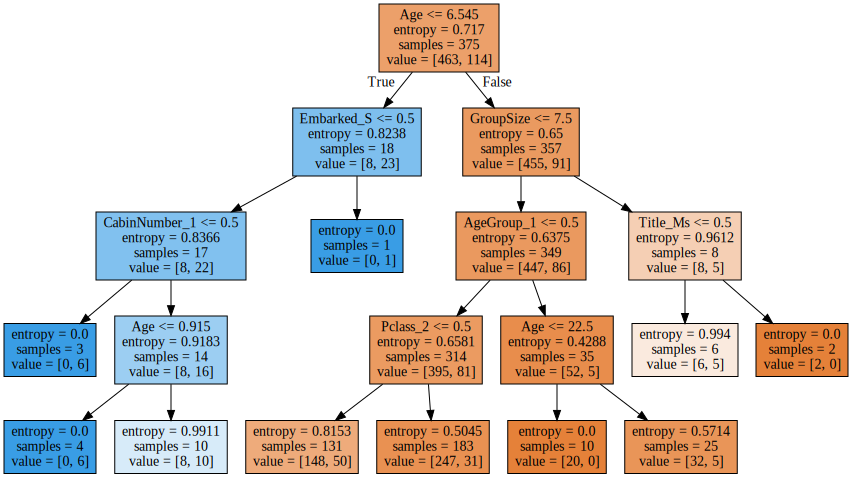

In [82]:
tree = export_graphviz(rfc_male.estimators_[69], out_file=None,
                       feature_names=X_test_ready.columns, filled=True)
graphviz.Source(tree, format="png")

In [51]:
feature_importances = pd.DataFrame()
for est in model.estimators_:
    feature_importances = feature_importances.append(pd.Series(est.feature_importances_, 
                                        index=X_test_ready.columns),
                             ignore_index=True)

In [52]:
feature_importances.mean().sort_values(ascending=False)

Age                               0.147476
Embarked_C                        0.131825
Sex_male                          0.095243
FareBracket_1                     0.067296
GroupSize                         0.060670
FamilyOnBoardType_single          0.035972
Title_Master                      0.029425
CabinNumber_0                     0.025368
Title_PublicService               0.025323
Title_Ms                          0.023764
Sex_female                        0.020109
FamilyOnBoardType_couple          0.017461
FareBracket_2                     0.016218
CabinNumber_1                     0.016176
Pclass_1                          0.015809
Pclass_2                          0.015668
AgeGroup_8                        0.014168
Pclass_3                          0.014015
FamilyOnBoardType_small_family    0.013375
FareBracket_4                     0.013121
FamilyOnBoardType_three           0.012466
Embarked_Q                        0.011978
FareBracket_3                     0.011413
AgeGroup_6 